# BM 336027 - Technion - Medical Image Processing


## Homework 3 - Image interpolation, Fourier domain operation and registration.
---

### <a style='color:red'> Due Date: 28.12.2022 </a>

---

### Agenda

* [Exercise 0: Phase and amplitude ](#Exercise-0)
* [Exercise 1: Phase correlation ](#Exercise-1)
* [Exercise 2: Image transformation and interpolation ](#Exercise-2)


#### Use as many cells as you need

In [1]:
# imports you will need
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.data import camera, coffee
from typing import Tuple
%matplotlib inline

C:\Users\appelm3\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


---

### **Assignment Instructions**
**In this assignment, you are allowed to use only basic numpy functions (including the module `np.fft`) and matplotlib functions, and functions you implemented in other sections of the exercises (unless otherwise instructed)**

---

### Exercise 0

1. In class, you learned about the importance of Fourier transform components. Recreate the figures you saw in class using the two images 'camera' and 'coffee'.<br>
    Load the images by calling the two functions with the same name imported from the skimage.data library. Note that you might need to transform the image from RGB to gray; you may use the function `rgb2gray` of skimage.color library that was imported in the first code block. <br>
    Crop the center of both images to the size 400x400.<br>
    Compute their Fourier transform and create two new images, one whose Fourier transform is made of the frequency magnitudes of the image 'coffee' and the frequency phases of 'camera' and vice versa.<br> 
    Display the images in one figure and add titles.
    

In [2]:
def crop_image(img, size):
    '''
    this function gets an image and cropped its center acoording to a given size.
    assume the given size is smaller than image.
    '''
    range_idx_w = int((img.shape[0] - size)/2), int((img.shape[0] + size)/2)
    range_idx_h = int((img.shape[1] - size)/2), int((img.shape[1] + size)/2)
    img_cropped = img[range_idx_w[0]:range_idx_w[1], range_idx_h[0]:range_idx_h[1]]
    return img_cropped

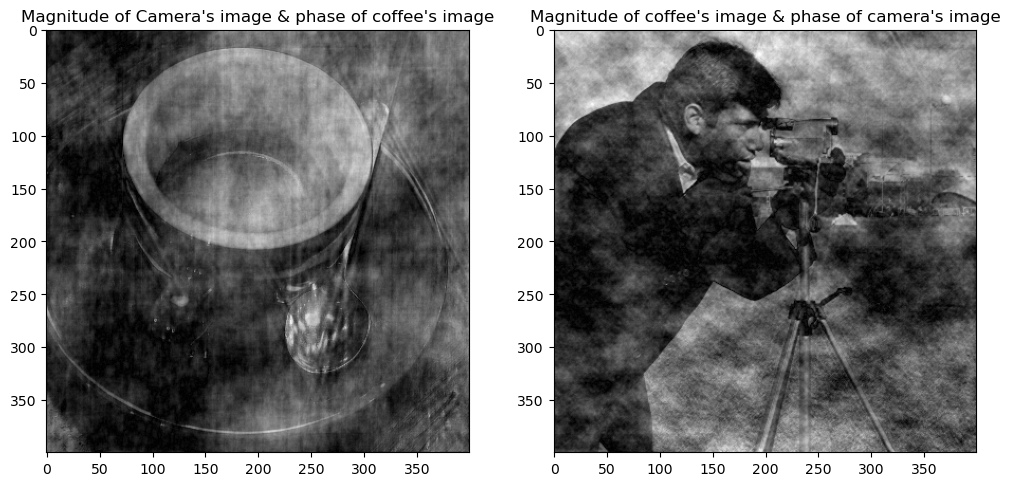

In [6]:
# ====== YOUR CODE: ======
# Load images and transform the image from RGB to gray.
camera_img = camera()
coffee_img = rgb2gray(coffee())

# Crop the center of both images to the size 400x400
camera_cropped = crop_image(camera_img, size=400)
coffee_cropped = crop_image(coffee_img, size=400)

# Compute Fourier transforms 
camera_fft = np.fft.fft2(camera_cropped) 
camera_mag = abs(camera_fft)
camera_phase = np.angle(camera_fft)

coffee_fft = np.fft.fft2(coffee_cropped)
coffee_mag = abs(coffee_fft)
coffee_phase = np.angle(coffee_fft)

# Create new image
img_cam_cof = np.fft.ifft2(camera_mag*np.exp(coffee_phase*1j))
img_cof_cam = np.fft.ifft2(coffee_mag*np.exp(camera_phase*1j))

# Display the images
titles = ["Magnitude of Camera's image & phase of coffee's image", "Magnitude of coffee's image & phase of camera's image"]
disp_img = [abs(img_cam_cof), abs(img_cof_cam)]

plt.figure(figsize=(12,12))
for i in range(2):
  plt.subplot(1, 2, i+1), plt.imshow(disp_img[i], cmap='gray'), plt.title(titles[i])

plt.show()
# ========================   

2.  Create an image whose Fourier transform is made of the frequency magnitude of random values and the frequency phases of one of the images above (camera or coffee). Display the image and add title. 

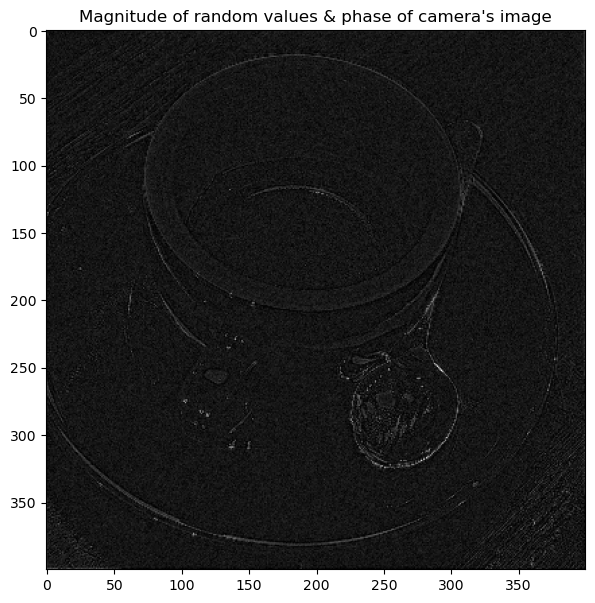

In [4]:
# ====== YOUR CODE: ======
rnd_vals = np.random.rand(400, 400)
rnd_mag = abs(np.fft.fft2(rnd_vals))
new_img = np.fft.ifft2(rnd_mag * np.exp(coffee_phase*1j))

plt.figure(figsize=(7,7))
plt.imshow(abs(new_img), cmap='gray'), plt.title("Magnitude of random values & phase of camera's image")
plt.show()
# ========================   

---

###  Exercise 1

In this exercise, you will implement a registration algorithm based on the Fourier transform, called phase correlation.<br> 
The phase correlation method is based on the Fourier shift theorem and is used to find the translation between two images.<br>
1. First, we want to get the magnitude and phase of the Fourier transform of the images. Implement the `fft_r_theta` function. The function should compute the FFT transform of the image and return two arrays; the first is the signal magnitude, and the second is the phase. Write a description of your function and explain its inputs and output.  

In [5]:
def fft_r_theta(img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    '''
    This function gets an image and computes its signal magnitude and phase's FFT transform.
    
    :param img: numpy array of an image.
    :return r: numpy array of the signal magnitude.
    :return theta: numpy array of the signal phase.
    '''
    # ====== YOUR CODE: ======
    img_fft = np.fft.fft2(img)
    r = abs(img_fft)
    theta = np.angle(img_fft)
    # ========================
    return r, theta

2. Load the images 'template.png' and 'moving.png' and compute their difference. <br>
    Display in one figure for each image (template, moving and the difference) the original image, its log magnitude and phase of their Fourier transform (3x3 grid of images). Add titles to your images.   

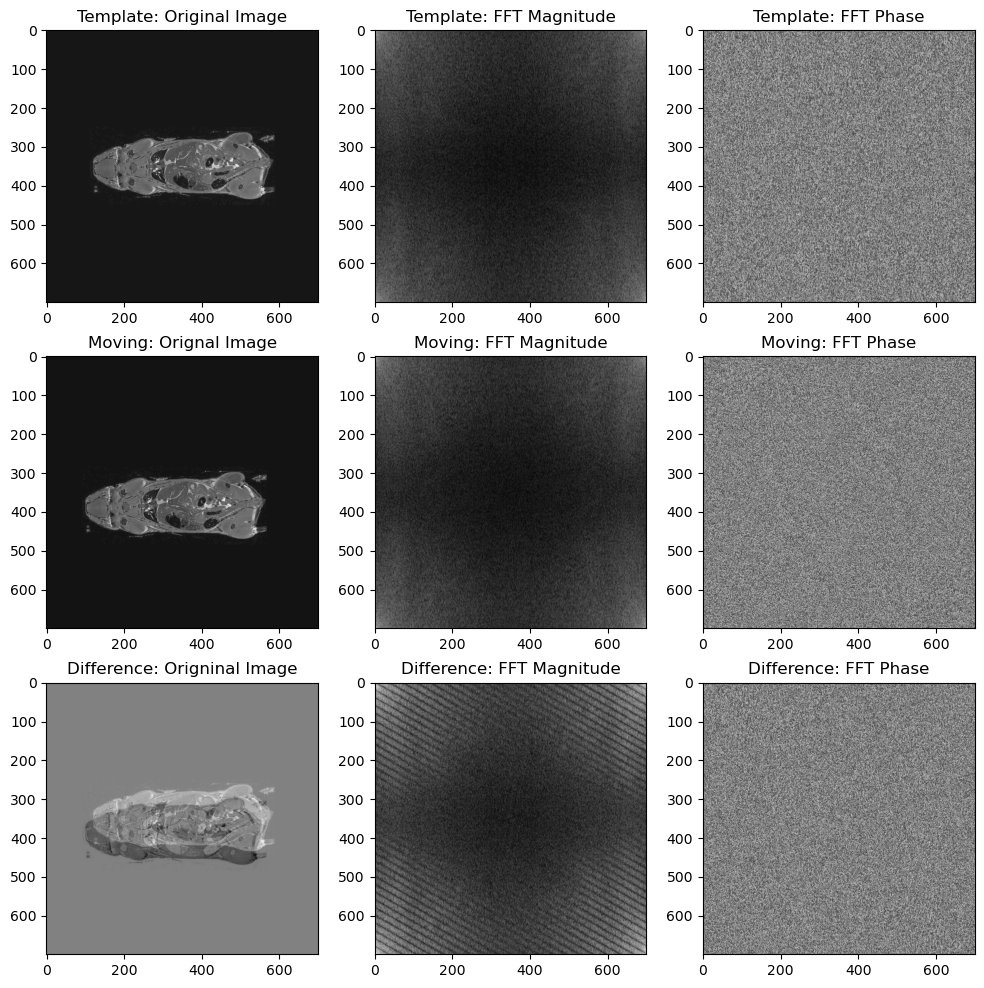

In [9]:
# ====== YOUR CODE: ======
template_img = plt.imread('images/template.png')
moving_img = plt.imread('images/moving.png')
diff = template_img - moving_img

template_mag, template_phase = fft_r_theta(template_img)
moving_mag, moving_phase = fft_r_theta(moving_img)
difference_mag, difference_phase = fft_r_theta(diff)

# Display the images
titles = ['Template: Original Image', 'Template: FFT Magnitude', 'Template: FFT Phase', 'Moving: Orignal Image', 'Moving: FFT Magnitude', 'Moving: FFT Phase', 'Difference: Origninal Image', 'Difference: FFT Magnitude', 'Difference: FFT Phase']
disp_img = [template_img, np.log(template_mag+1), template_phase, moving_img, np.log(moving_mag+1), moving_phase, diff, np.log(difference_mag+1), difference_phase]

plt.figure(figsize=(12,12))
for i in range(9):
  plt.subplot(3, 3, i+1), plt.imshow(disp_img[i], cmap='gray'), plt.title(titles[i])

plt.show()
# ========================

Now, we want to find the translation between the two images and the required correction.<br>
Based on the Fourier shift theorem, we can express the images $f_1,f_2$ as follows:
    
$$
f_2(x,y)=f_1(x-t_x,y-t_y)\\
F_2(u,v)=e^{-2j\pi(ut_x+vt_y)}F_1(u,v)
$$

where $t_x, t_y$ represent the translation and $F_1,F_2$ are the Fourier transforms of the images $f_1,f_2$ respectivly.<br> 

The translation between two images $f_1,f_2$ can be found using the normalized cross power spectrum (CPS): 
$$
e^{-2j\pi(ut_x+vt_y)}=\frac{F_1(u,v)F^*_2(u,v)}{|F_1(u,v)F^*_2(u,v)|}
$$
where $F^*_2$ is the complex conjugate of $F_2$


The term $e^{-2j\pi(ut_x+vt_y)}$ is the Fourier transform of the shifted Dirac delta function. Hence, we can calculate $t_x,t_y$ by computing the inverse Fourier transform of the CPS and finding the location of the peak.


2. Implement the function `phase_correlation` that gets two images and returns the translation between them in the x and y axes, and the reconstructed image (the moving image after the required shifting). Write a description of your function and explain its inputs and output.

In [10]:
def phase_correlation(img1: np.ndarray, img2: np.ndarray)-> Tuple[int, int, np.ndarray]:
    '''
    This function retuerns the translation between two given images. 
    
    :param img1: numpy array of an image
    :param img2: numpy array of an image
    :return res_dx: translation distance between the images in the x axis (int)
    :return res_dy: translation distance between the images in the y axis (int)
    :return corr_img: numpy array of the reconstructed image
    '''
    # ====== YOUR CODE: ======
    F1 = np.fft.fft2(img1) 
    F2 = np.fft.fft2(img2)
    F2_conj = np.conjugate(F2) 
    
    # normalized cross power spectrum
    cps = (F1 * F2_conj) / abs(F1 * F2_conj)

    # inverse Fourier transform of the CPS 
    cps_ifft = np.fft.ifft2(cps)

    # finding the location of the peak
    cps_ifft_peak = np.argwhere(cps_ifft == cps_ifft.max())
    res_dx = cps_ifft.shape[0]-cps_ifft_peak[0][1]
    res_dy = cps_ifft.shape[0]-cps_ifft_peak[0][0]

    # the moving image after the required shifting
    corr_img = abs(np.fft.ifft2(cps * F2))
    # ======================== 
    return res_dx, res_dy, corr_img

3. Find the translation between the tamplate image and the moving image and the reconstructed image using the  `phase_correlation`.<br>
    Print the translation in the x and y axes and display in one figure the moving image, the reconstructed image and the difference between the template image and the reconstructed image. Add titles.  

The translation in the x axis is 680 and in the y axis is 35.


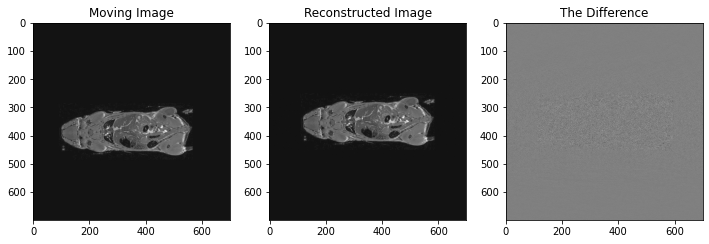

In [ ]:
# ====== YOUR CODE: ======
tx, ty, rec_img = phase_correlation(template_img, moving_img)
diff_img = template_img - rec_img

print(f'The translation in the x axis is {tx} and in the y axis is {ty}.')

plt.figure(figsize=(12,12))
plt.subplot(131), plt.imshow(moving_img, cmap='gray'), plt.title('Moving Image')
plt.subplot(132), plt.imshow(rec_img, cmap='gray'), plt.title('Reconstructed Image')
plt.subplot(133), plt.imshow(diff_img, cmap='gray'), plt.title('The Difference')
plt.show()
# ======================== 

4. The peak signal to noise ratio, or PSNR, is a metric of image quality.
$$ PSNR = 20*log_{10}\left(\frac{I_{max}}{\sqrt{\sigma^2}}\right) $$
Where $I_{max}$ is the maximal image value and $\sigma^2$ is the variance of the noise in the image.
The images provided to you have no noise in them. Add normally distributed noise to both images such that the PSNR will be 25. Now use your algorithm on the noisy images (template and moving) and try to match them again.  <br>
Display in one figure the moving image, the reconstructed image and the difference between the template image and the reconstructed image. Add titles.  

(<matplotlib.axes._subplots.AxesSubplot at 0x7f9e2224cac0>,
 Text(0.5, 1.0, 'Difference'))

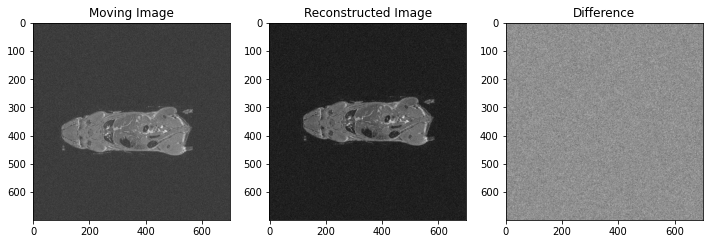

In [ ]:
# ====== YOUR CODE: ======
psnr = 25

# maximal image value
i_max_template = np.max(template_img)  
i_max_moving = np.max(moving_img)

# variance of the noise
sig_template = i_max_template / np.power(10,(psnr/20))   
sig_moving = i_max_moving / np.power(10,(psnr/20))

# Add normally distributed noise to both images
noise_template = np.random.normal(0, sig_template, template_img.shape)
noise_moving = np.random.normal(0, sig_moving, moving_img.shape)
noisy_template_img = template_img + noise_template
noisy_moving_img = moving_img + noise_moving

# Use your algorithm on the noisy images and try to match them again.
tx, ty, rec_img = phase_correlation(noisy_template_img, noisy_moving_img)
diff = noisy_template_img - rec_img

plt.figure(figsize=(12,12))
plt.subplot(131), plt.imshow(noisy_moving_img, cmap='gray'), plt.title('Moving Image')
plt.subplot(132), plt.imshow(rec_img, cmap='gray'), plt.title('Reconstructed Image')
plt.subplot(133), plt.imshow(diff, cmap='gray'), plt.title('Difference')
# ======================== 

5. Repeat the previous task for different levels of PSNR until you find the lowest PSNR for which your algorithm works.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f9e21cc4f70>,
 Text(0.5, 1.0, 'Difference'))

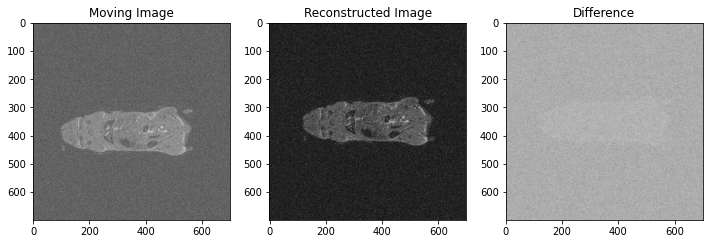

In [ ]:
# ====== YOUR CODE: ======
psnr = 16

# maximal image value
i_max_template = np.max(template_img)  
i_max_moving = np.max(moving_img)

# variance of the noise
sig_template = i_max_template / np.power(10,(psnr/20))   
sig_moving = i_max_moving / np.power(10,(psnr/20))

# Add normally distributed noise to both images
noise_template = np.random.normal(0, sig_template, template_img.shape)
noise_moving = np.random.normal(0, sig_moving, moving_img.shape)
noisy_template_img = template_img + noise_template
noisy_moving_img = moving_img + noise_moving

# Use your algorithm on the noisy images and try to match them again.
tx, ty, rec_img = phase_correlation(noisy_template_img, noisy_moving_img)
diff = noisy_template_img - rec_img

plt.figure(figsize=(12,12))
plt.subplot(131), plt.imshow(noisy_moving_img, cmap='gray'), plt.title('Moving Image')
plt.subplot(132), plt.imshow(rec_img, cmap='gray'), plt.title('Reconstructed Image')
plt.subplot(133), plt.imshow(diff, cmap='gray'), plt.title('Difference')
# ========================

---

### Exercise 2

In this exercise, you will implement image transformations and pixel value interpolation.<br>
1. Implement the function `back_project` that recieves a 3x3 transformation matrix (source to destination) and a destination image size as a tuple $(h, w)$ and returns the coordinates of the transformed destination pixels in the source image $(h, w, 2)$.   
Write a description of your function and explain its inputs and output.

In [50]:
def back_project(mapping: np.ndarray, size: tuple) -> np.ndarray:
    '''
    This function gets a transformation matrix and a destination image size and
     produce the coordinates of the transformed destination pixels in the image.

    :param mapping: 3X3 transformation matrix
    :param size: destination image size (h, w)
    :return source_coords: coordinates of the transformed destination pixels in
     the source image (h, w, 2)
    '''
    # ====== YOUR CODE: ======
    source_coords = np.zeros((size[0], size[1], 2))   
    
    for i in range(size[0]):
        for j in range(size[1]):
            source_coords[i,j,0] = i*mapping[0,0] + j*mapping[0,1] + mapping[0,2]
            source_coords[i,j,1] = i*mapping[1,0] + j*mapping[1,1] + mapping[1,2]   
    # ========================
    return source_coords



2. Implement the function `general_rotation_matrix` that recieves a rotation angle and the center of rotations and creates a transformation for a rotation about the given center (y, x).    
Write a description of your function and explain its inputs and output.

In [15]:
def general_rotation_matrix(degrees: np.ndarray, center: np.ndarray) -> np.ndarray:
    '''
    This function recieves a rotation angle and the center of rotations and
     produce a transformation matrix.
    
    :param degrees: rotation angle [rad]
    :param center: the center's coordinates (y, x)
    :return rotate_mat: the rotation transformation around the center
    '''
    # ====== YOUR CODE: ======
    x, y = center[1], center[0]
    
    rotation = np.array([[np.cos(degrees), -np.sin(degrees), 0], [np.sin(degrees), np.cos(degrees), 0], [0, 0, 1]])
    trans1 = np.array([[1, 0, x], [0, 1, y], [0, 0, 1]])
    trans2 = np.array([[1, 0, -x], [0, 1, -y], [0, 0, 1]])
    rotate_mat = trans1 @ rotation @ trans2
    # ========================
    return rotate_mat

3. Now that we have the positions of the transformed pixels in the source image, we can compute their values using interpolation.<br>
Implement the function `bilinear_interpolation` that receives the source image and an array with the shape $[h, w, 2]$ that contains the subpixel coordinates of the transformed pixels and computes their values using bilinear interpolation.<br>
Write a description of your function and explain its inputs and output.

In [21]:
def bilinear_interpolation(source: np.ndarray, coords: np.ndarray) -> np.ndarray:
    '''
    This function gets a source image and an array with the subpixel coordinates 
    of the transformed pixels and produce their values using bilinear interpolation.
    
    :param source: the source image
    :param coords: coordinates of transformed pixels [h,w,2]
    :return interpolation: an interpolated image
    '''
    # ====== YOUR CODE: ======
    interpolation = np.zeros(source.shape)
    src_i,src_j = source.shape
    
    for i in range(src_i):
        for j in range(src_j):

            x, y = coords[i,j,1], coords[i,j,0]

            if 0<x<src_j-1 and 0<y<src_i-1:
                NW = (int(np.floor(y)), int(np.floor(x)))
                NE = (int(np.floor(y)), int(np.ceil(x)))
                SW = (int(np.ceil(y)), int(np.floor(x)))
                SE = (int(np.ceil(y)), int(np.ceil(x)))

                u = x - int(np.floor(x))
                v = y - int(np.ceil(y))

                Su = source[SE]*u + source[SW]*(1-u)
                Nu = source[NE]*u + source[NW]*(1-u)

                interpolation[i,j] += Nu*v + Su*(1-v)  
    # ========================        
    return interpolation

Run this block to get an example image from scipy.    
Don't forget to adjust it according to your needs.

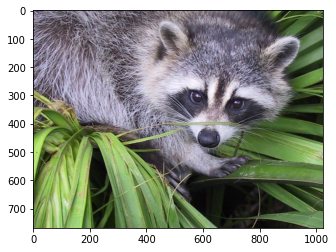

In [17]:
from scipy import misc

f= misc.face()
plt.imshow(f)
plt.show()


4. Use your functions to create 4 different rotation matrices (4 different angles and 3 different rotation canters).    
Plot the image rotated using each rotation matrix.   
Add a title to each figure specifying the rotation angle and the center of rotation.

<ipython-input-51-ee3c400bd2ff>:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  fig = rgb2gray(f)


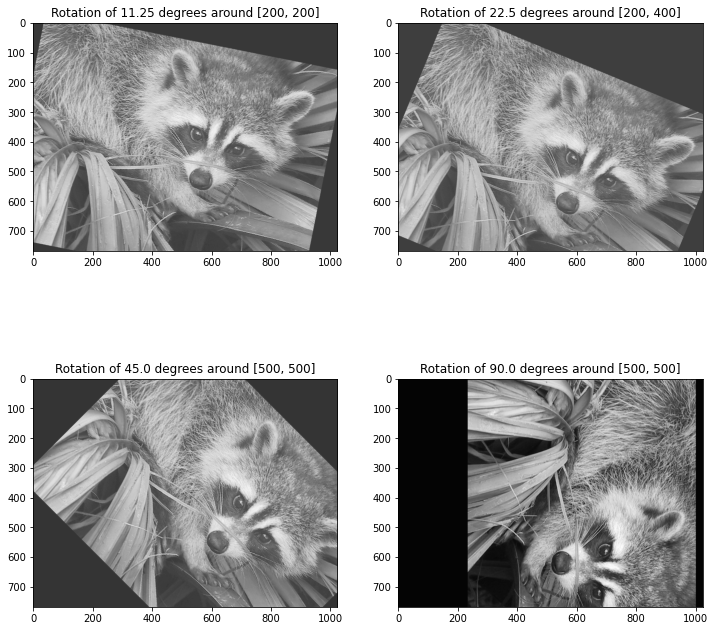

In [51]:
# ====== YOUR CODE: ======
angles = [np.pi/16, np.pi/8, np.pi/4, np.pi/2]
centers = [[200,200], [200,400], [500,500], [500,500]]

fig = rgb2gray(f)
fig_size = fig.shape
inrpl = np.zeros([fig_size[0],fig_size[1],4]) 
plt.figure(figsize=(12,12))
titles = []

for i in range (4):
    rotation_mat = general_rotation_matrix(angles[i],centers[i])
    coords = back_project(rotation_mat, tuple(fig_size))
    inrpl[:,:,i] = bilinear_interpolation(fig,coords)
    titles.append('Rotation of '+str(angles[i]*180/np.pi)+' degrees around '+str(centers[i]))

    plt.subplot(2, 2, i+1)
    plt.imshow(inrpl[:,:,i], cmap='gray')
    plt.title(titles[i])

plt.show()
# ======================== 

**Questions:**

5. After applying a sequence of basic affine transformations on the left image, we received the right image. Which affine transformations were applied, and in what order? Write the matrix representation of the transformations.  

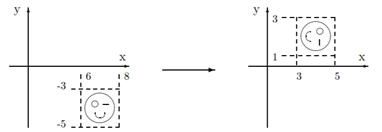   





**Answer:**

The affine transformations that were applied are: The rotation x0=8, y0=-3 by -90 degrees, and the translation: tx=-3, ty=4 afterwords.

$$
\begin{bmatrix}
x' \\
y'\\
1
\end{bmatrix}
=
\begin{bmatrix}
1 & 0 & 8  \\
0 & 1 & -3  \\
0 & 0 & 1  \\
\end{bmatrix}
\begin{bmatrix}
cos(-90) & -sin(-90) & 0  \\
sin(-90) & cos(-90) & 0  \\
0 & 0 & 1  \\
\end{bmatrix}
\begin{bmatrix}
1 & 0 & -8  \\
0 & 1 & 3  \\
0 & 0 & 1  \\
\end{bmatrix}
\begin{bmatrix}
x\\
y\\
1
\end{bmatrix}
+
\begin{bmatrix}
-3 \\
4\\
0
\end{bmatrix}
$$

6. To rotate the original image (1), we used nearest neighbor interpolation and bilinear linear interpolation (images 2,3). What interpolation was used in each image (2,3). Explain how you reached that conclusion.      
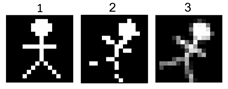    


**Answer:**

Image 2: nearest neighbor interpolation <br>
The simpleset method, using rounded values to the nearest pixel. thus we can see the information lost as the missing pixels.

Image 3: bilinear interpolation <br>
This method replace the wanted pixels with a weighted average of the nearest pixels on the boundary. It caused the white-gray pixels in the edges.